In [41]:
# ============================================================
# STEP 1 — Setup: Libraries & Configuration
# ============================================================

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import folium
from IPython.display import display, IFrame
from google.colab import files

random.seed(42)
np.random.seed(42)


In [42]:
# ============================================================
# STEP 2 — Load and Balance Dataset (Reduce Environmental Risk)
# ============================================================

df = pd.read_csv("synthetic_maritime_dataset.csv")

# Reduce environmental risk count
env_rows = df[df["label"] == "environment_risk"]
keep_env = env_rows.sample(n=min(70, len(env_rows)), random_state=42)
df_non_env = df[df["label"] != "environment_risk"]
df_balanced = pd.concat([df_non_env, keep_env]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Final balanced dataset: {len(df_balanced)} records")
print(df_balanced['label'].value_counts())

✅ Final balanced dataset: 1250 records
label
crossed      611
safe         369
high_risk    270
Name: count, dtype: int64


In [43]:
# ============================================================
# STEP 3 — Encode + Split Dataset
# ============================================================

encoders = {}
for col in ["zone_type", "historical_pattern"]:
    le = LabelEncoder()
    df_balanced[col] = le.fit_transform(df_balanced[col])
    encoders[col] = le

le_label = LabelEncoder()
df_balanced["label_encoded"] = le_label.fit_transform(df_balanced["label"])

features = ["lon","lat","speed","heading","speed_change","stop_duration",
            "wind_speed","wave_height","rainfall","visibility",
            "zone_type","historical_pattern"]

X = df_balanced[features]
y = df_balanced["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)


✅ Label distribution after adding environmental risk:
final_status
environment_risk    611
crossed             325
safe                179
high_risk           135
Name: count, dtype: int64 

Classification Accuracy — Train: 0.989 | Test: 0.904

🎯 Classification Report:

                  precision    recall  f1-score   support

         crossed       0.90      0.92      0.91        65
environment_risk       0.92      0.89      0.90       122
       high_risk       0.86      0.93      0.89        27
            safe       0.92      0.92      0.92        36

        accuracy                           0.90       250
       macro avg       0.90      0.91      0.90       250
    weighted avg       0.90      0.90      0.90       250



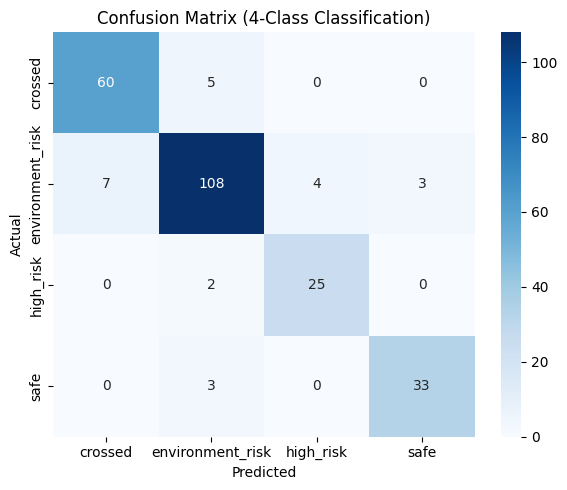

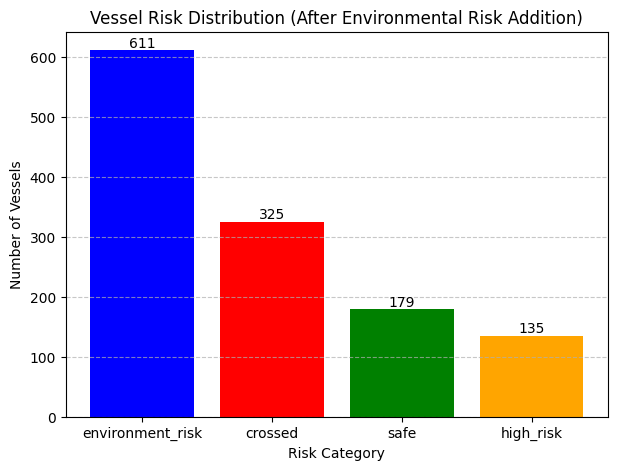

/tmp/ipython-input-505715096.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")


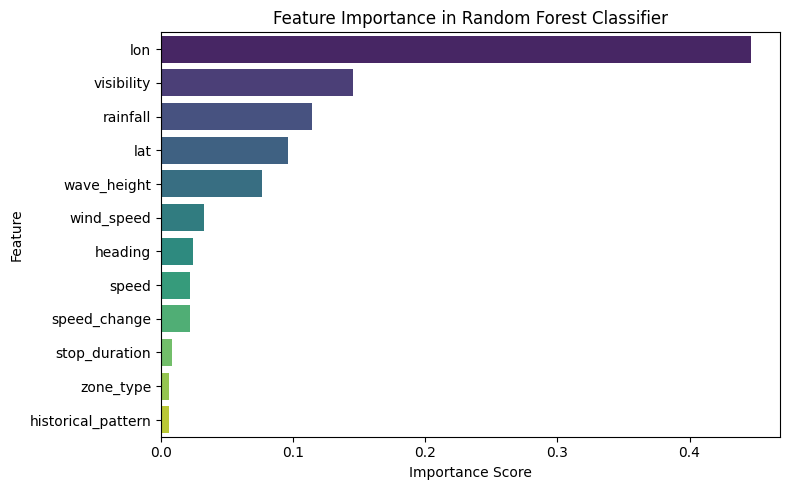


⏱️ Training Regression Model for ETA Prediction...

⏱️ Regression MAE: 0.81 hr (≈ 49 min)
📊 Regression R²: 0.808



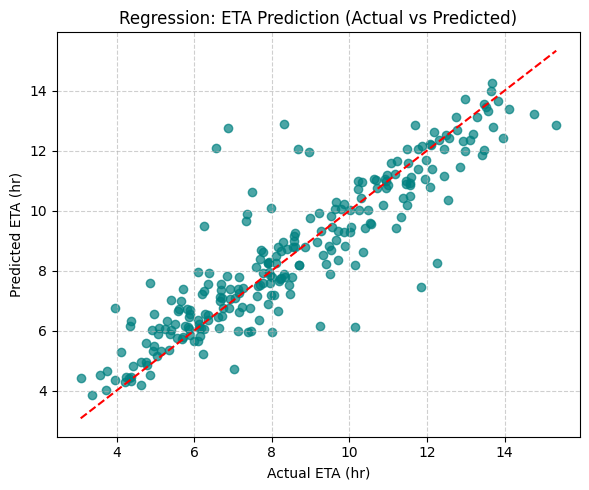

In [44]:
# ------------------------------------------------------------
# 2️⃣ Add slight randomness to avoid 100% accuracy
# ------------------------------------------------------------
np.random.seed(42)
df["wind_speed"] += np.random.normal(0, 2, len(df))
df["wave_height"] += np.random.normal(0, 0.25, len(df))
df["rainfall"] += np.random.normal(0, 5, len(df))
df["visibility"] += np.random.normal(0, 0.4, len(df))
df["speed"] += np.random.normal(0, 0.5, len(df))

# Clip to valid ranges
df["wind_speed"] = df["wind_speed"].clip(lower=0)
df["wave_height"] = df["wave_height"].clip(lower=0)
df["rainfall"] = df["rainfall"].clip(lower=0)
df["visibility"] = df["visibility"].clip(lower=0.5)
df["speed"] = df["speed"].clip(lower=0.5)

# ------------------------------------------------------------
# 3️⃣ Add environmental risk dynamically
# ------------------------------------------------------------
def combined_status(row):
    wind_limit = np.random.uniform(24, 28)
    wave_limit = np.random.uniform(3.0, 4.0)
    rain_limit = np.random.uniform(70, 90)
    vis_limit = np.random.uniform(2.5, 3.5)

    if (
        row["wind_speed"] > wind_limit
        or row["wave_height"] > wave_limit
        or row["rainfall"] > rain_limit
        or row["visibility"] < vis_limit
    ):
        return "environment_risk"
    else:
        return row["label"]

df["final_status"] = df.apply(combined_status, axis=1)

print("✅ Label distribution after adding environmental risk:")
print(df["final_status"].value_counts(), "\n")

# ------------------------------------------------------------
# 🧭 Optional — Create synthetic ETA (time_to_cross_hr) column for regression demo
# ------------------------------------------------------------
if "time_to_cross_hr" not in df.columns:
    np.random.seed(42)
    base_eta = 10 - (df["speed"] / 3)  # faster ships, lower ETA
    risk_adjustment = df["final_status"].map({
        "crossed": 1.0,
        "high_risk": 1.4,
        "safe": 0.9,
        "environment_risk": 1.6
    }).fillna(1.2)
    noise = np.random.normal(0, 0.5, len(df))
    df["time_to_cross_hr"] = (base_eta * risk_adjustment + noise).clip(lower=0.5)

# ------------------------------------------------------------
# 4️⃣ Encode categorical variables
# ------------------------------------------------------------
encoders = {}
for col in ["zone_type", "historical_pattern"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

le_label = LabelEncoder()
df["label_encoded"] = le_label.fit_transform(df["final_status"])

# ------------------------------------------------------------
# 5️⃣ Features
# ------------------------------------------------------------
features = [
    "lon", "lat", "speed", "heading", "speed_change", "stop_duration",
    "wind_speed", "wave_height", "rainfall", "visibility",
    "zone_type", "historical_pattern"
]
X = df[features]
y = df["label_encoded"]

# ------------------------------------------------------------
# 6️⃣ Split data
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

# ------------------------------------------------------------
# 7️⃣ Train RandomForestClassifier
# ------------------------------------------------------------
clf = RandomForestClassifier(
    n_estimators=150, max_depth=10, random_state=42, class_weight="balanced"
)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print(f"Classification Accuracy — Train: {train_acc:.3f} | Test: {test_acc:.3f}\n")
print("🎯 Classification Report:\n")
print(classification_report(y_test, y_pred_test, target_names=le_label.classes_))

# ------------------------------------------------------------
# 8️⃣ Confusion Matrix (Plot 1)
# ------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_label.classes_, yticklabels=le_label.classes_)
plt.title("Confusion Matrix (4-Class Classification)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 9️⃣ Bar Chart — Risk Distribution (Plot 2)
# ------------------------------------------------------------
risk_counts = df["final_status"].value_counts()
colors = {
    "safe": "green",
    "high_risk": "orange",
    "crossed": "red",
    "environment_risk": "blue"
}

plt.figure(figsize=(7,5))
bars = plt.bar(risk_counts.index, risk_counts.values,
               color=[colors.get(x, "gray") for x in risk_counts.index])
plt.title("Vessel Risk Distribution (After Environmental Risk Addition)")
plt.xlabel("Risk Category")
plt.ylabel("Number of Vessels")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', fontsize=10)
plt.show()

# ------------------------------------------------------------
# 🔟 Feature Importance Bar Chart (Plot 3)
# ------------------------------------------------------------
importances = clf.feature_importances_
feature_df = pd.DataFrame({"Feature": features, "Importance": importances})
feature_df = feature_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")
plt.title("Feature Importance in Random Forest Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 1️⃣1️⃣ Regression Model (Plot 4 + Metrics)
# ------------------------------------------------------------
print("\n⏱️ Training Regression Model for ETA Prediction...\n")
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, df.loc[X_train.index, "time_to_cross_hr"])
y_pred_eta = reg.predict(X_test)

mae = mean_absolute_error(df.loc[X_test.index, "time_to_cross_hr"], y_pred_eta)
r2 = r2_score(df.loc[X_test.index, "time_to_cross_hr"], y_pred_eta)

# Convert MAE (hours) to minutes
mae_minutes = mae * 60

print(f"⏱️ Regression MAE: {mae:.2f} hr (≈ {mae_minutes:.0f} min)")
print(f"📊 Regression R²: {r2:.3f}\n")

plt.figure(figsize=(6,5))
plt.scatter(df.loc[X_test.index, "time_to_cross_hr"], y_pred_eta,
            color="teal", alpha=0.7)
plt.plot([df["time_to_cross_hr"].min(), df["time_to_cross_hr"].max()],
         [df["time_to_cross_hr"].min(), df["time_to_cross_hr"].max()],
         color="red", linestyle="--")
plt.xlabel("Actual ETA (hr)")
plt.ylabel("Predicted ETA (hr)")
plt.title("Regression: ETA Prediction (Actual vs Predicted)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [50]:
# ============================================================
# STEP 5 — Sliding Window (IMBL Direction + Animated Dashboard, Fixed)
# ============================================================

import pandas as pd, geopandas as gpd, folium, numpy as np, time
from shapely.geometry import Point
from google.colab import files
from math import radians, sin, cos, asin, sqrt

# ------------------------------------------------------------
# 1️⃣ Load dataset and shapefiles
# ------------------------------------------------------------
df = pd.read_csv("synthetic_maritime_dataset.csv")
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

imbl = gpd.read_file("India_IMBL.shp")
if imbl.crs is None:
    imbl.set_crs("EPSG:4326", inplace=True)
else:
    imbl = imbl.to_crs("EPSG:4326")

# Create IMBL boundary line
if imbl.geometry.iloc[0].geom_type in ["Polygon", "MultiPolygon"]:
    imbl_line = imbl.geometry.boundary.unary_union
elif imbl.geometry.iloc[0].geom_type in ["LineString", "MultiLineString"]:
    imbl_line = imbl.geometry.unary_union

land = gpd.read_file("ne_10m_admin_0_countries.shp")
land = land[(land["NAME"] == "India") | (land["NAME"] == "Sri Lanka")]
land_union = land.geometry.unary_union

# ------------------------------------------------------------
# 2️⃣ Helper: Haversine distance (for km)
# ------------------------------------------------------------
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return 2*R*asin(sqrt(a))

# ------------------------------------------------------------
# 3️⃣ Improved classification (direction-aware)
# ------------------------------------------------------------
def classify_vessel(point):
    if point.within(land_union):
        return "invalid"
    nearest_point = imbl_line.interpolate(imbl_line.project(point))
    dist_km = haversine_distance(point.y, point.x, nearest_point.y, nearest_point.x)
    side_diff = point.x - nearest_point.x  # +ve = east (crossed), -ve = west (India)

    if side_diff > 0.02:  # east of IMBL ≈ crossed
        return "crossed"
    elif 0 <= side_diff <= 0.02 and dist_km <= 5:
        return "high_risk"
    else:
        return "safe"

gdf["base_status"] = gdf["geometry"].apply(classify_vessel)
gdf_final = gdf[~gdf["base_status"].isin(["invalid"])].reset_index(drop=True)

# Snap crossed vessels onto IMBL
def snap_to_imbl(point):
    nearest_point = imbl_line.interpolate(imbl_line.project(point))
    return nearest_point

crossed_mask = gdf_final["base_status"] == "crossed"
gdf_final.loc[crossed_mask, "geometry"] = gdf_final[crossed_mask]["geometry"].apply(snap_to_imbl)

# ------------------------------------------------------------
# 4️⃣ Environmental overlay
# ------------------------------------------------------------
safe_vessels = gdf_final[gdf_final["base_status"] == "safe"].copy()
env_risk_ids = []
if len(safe_vessels) >= 20:
    window1_safe = safe_vessels.iloc[:len(safe_vessels)//2]
    window2_safe = safe_vessels.iloc[len(safe_vessels)//2:]
    env_risk_ids_w1 = window1_safe.sample(n=10, random_state=42).index
    env_risk_ids_w2 = window2_safe.sample(n=10, random_state=24).index
    env_risk_ids = list(env_risk_ids_w1) + list(env_risk_ids_w2)

gdf_final["environment_flag"] = gdf_final.index.isin(env_risk_ids)
gdf_final["final_status"] = gdf_final.apply(
    lambda r: f"{r['base_status']} + environmental_risk" if r["environment_flag"] else r["base_status"],
    axis=1
)

# ------------------------------------------------------------
# 5️⃣ Fix CRS & Create Buffers (no warning)
# ------------------------------------------------------------
# Convert to projected CRS (meters) for accurate buffering
imbl_projected = gpd.GeoSeries([imbl_line], crs="EPSG:4326").to_crs(epsg=32644)  # UTM Zone 44N (covers Tamil Nadu)
inner_buffer_proj = imbl_projected.buffer(5000)   # 5 km
outer_buffer_proj = imbl_projected.buffer(10000)  # 10 km
pre_warning_zone_proj = outer_buffer_proj.difference(inner_buffer_proj)

# Convert back to geographic CRS for Folium display
inner_buffer = inner_buffer_proj.to_crs(epsg=4326)
pre_warning_zone = pre_warning_zone_proj.to_crs(epsg=4326)

# ------------------------------------------------------------
# 6️⃣ Dashboard with blinking animation
# ------------------------------------------------------------
def create_dashboard_window(gdf, start, end, window_no):
    subset = gdf.iloc[start:end]
    m = folium.Map(location=[9.0, 79.5], zoom_start=7, tiles="cartodb positron")

    # IMBL & buffers
    folium.GeoJson(imbl_line, style_function=lambda x: {"color": "red", "weight": 3}).add_to(m)
    folium.GeoJson(inner_buffer, style_function=lambda x: {"color": "pink", "fillColor": "pink", "fillOpacity": 0.25}).add_to(m)
    folium.GeoJson(pre_warning_zone, style_function=lambda x: {"color": "gray", "fillColor": "gray", "fillOpacity": 0.1}).add_to(m)

    # Blinking animation CSS
    css = """
    <style>
    @keyframes pulse {
      0% { transform: scale(1); opacity: 1; }
      50% { transform: scale(1.5); opacity: 0.4; }
      100% { transform: scale(1); opacity: 1; }
    }
    </style>
    """
    m.get_root().header.add_child(folium.Element(css))

    for _, row in subset.iterrows():
        lat, lon = row.geometry.y, row.geometry.x
        if "crossed" in row["final_status"]:
            color, pulse = "red", True
        elif "high_risk" in row["final_status"]:
            color, pulse = "orange", True
        elif "environmental" in row["final_status"]:
            color, pulse = "blue", False
        else:
            color, pulse = "green", False

        nearest_point = imbl_line.interpolate(imbl_line.project(Point(lon, lat)))
        dist_km = haversine_distance(lat, lon, nearest_point.y, nearest_point.x)

        tooltip_html = f"""
        <div style='font-size:13px; line-height:1.4'>
        🆔 <b>{row.get('mmsi', 'N/A')}</b><br>
        📍 <b>Status:</b> {row['final_status']}<br>
        🧭 <b>Distance to IMBL:</b> {dist_km:.2f} km
        </div>
        """

        marker_html = f"""
        <div style='
            background:{color};
            width:14px; height:14px;
            border-radius:50%;
            {"animation:pulse 1.2s infinite;" if pulse else ""}
            border:2px solid white;
            box-shadow:0 0 6px {color};
        '></div>
        """

        folium.Marker(location=[lat, lon],
                      tooltip=tooltip_html,
                      icon=folium.DivIcon(html=marker_html)).add_to(m)

    # Legend
    legend_html = """
    <div style="position: fixed; bottom: 30px; left: 30px; width: 240px;
                background-color: white; border:2px solid grey; border-radius:10px;
                box-shadow:2px 2px 6px rgba(0,0,0,0.3); z-index:9999; padding:10px; font-size:13px;">
      <b>⚓ Vessel Risk Legend</b><br>
      🟢 Safe<br>🟠 High Risk (≤5 km, blinking)<br>🔴 Crossed (Snapped, blinking)<br>🔵 Environmental Risk<br>
      <span style="color:pink;">▌</span> 5 km High-risk Zone<br>
      <span style="color:gray;">▌</span> 5–10 km Pre-warning Zone
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    file_path = f"/content/CoastGuard_Dashboard_Window{window_no}_Animated.html"
    m.save(file_path)
    time.sleep(2)
    files.download(file_path)
    print(f"✅ Animated dashboard {window_no} saved → {file_path}")
    return file_path

# ------------------------------------------------------------
# 7️⃣ Generate only TWO dashboards (no duplicates)
# ------------------------------------------------------------
window1 = gdf_final.sample(n=100, random_state=42)
file1 = create_dashboard_window(window1, 0, len(window1), 1)

remaining = gdf_final.drop(window1.index)
window2 = remaining.sample(n=100, random_state=99)
file2 = create_dashboard_window(window2, 0, len(window2), 2)

print("\n✅ Animated dashboards created successfully!")


/tmp/ipython-input-3992493264.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  imbl_line = imbl.geometry.boundary.unary_union
/tmp/ipython-input-3992493264.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  land_union = land.geometry.unary_union


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Animated dashboard 1 saved → /content/CoastGuard_Dashboard_Window1_Animated.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Animated dashboard 2 saved → /content/CoastGuard_Dashboard_Window2_Animated.html

✅ Animated dashboards created successfully!


In [51]:
# ============================================================
# STEP 6 — Advanced Vessel Alert Simulation with Distance & ETA
# ============================================================

from shapely.geometry import Point
from math import radians, cos, sin, asin, sqrt

# --- Haversine distance (in kilometers) ---
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius (km)
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

# --- Enhanced alert with distance and ETA ---
def simulate_vessel_alert(mmsi, lat, lon, speed, wave, wind, vis):
    """
    Simulates dynamic coastal alerts using both positional and environmental parameters.
    Adds real-time distance computation and estimated crossing time to IMBL.
    """
    # Define IMBL longitude threshold (approx. 79.5°)
    IMBL_LON = 79.5

    # Compute distance to IMBL (approx. distance to longitude 79.5)
    dist_km = haversine_distance(lat, lon, lat, IMBL_LON)

    # Compute ETA (time to cross, in minutes)
    # 1 knot ≈ 1.852 km/h
    if speed > 0:
        eta_hr = dist_km / (speed * 1.852)
        eta_min = eta_hr * 60
    else:
        eta_min = float('inf')

    # Determine zone classification
    if lon < 78.5:
        status = "safe"
    elif 78.5 <= lon <= 79.5:
        status = "high_risk"
    else:
        status = "crossed"

    env_risk = (wave > 3.5) or (wind > 25) or (vis < 3)

    print(f"\n📡 Vessel {mmsi} | Location: ({lat:.2f}, {lon:.2f}) | Speed: {speed:.1f} knots")

    if status == "crossed":
        print(f"🚨 Alert: You have already crossed into Sri Lankan waters!")
        print(f"🧭 Distance beyond IMBL: {dist_km:.2f} km")
        if env_risk:
            print("🌊 Environmental Warning: Severe conditions detected! Return immediately.")
    elif status == "high_risk":
        print(f"⚠️ Warning: You are {dist_km:.2f} km from the IMBL.")
        if eta_min < 60:
            print(f"⏱ Estimated crossing in approximately {eta_min:.1f} minutes at {speed:.1f} knots.")
        else:
            print(f"⏱ Estimated crossing in over an hour at {speed:.1f} knots.")
        print("👉 Suggestion: Reduce speed or alter course to remain within Indian waters.")
        if env_risk:
            print("🌊 Additional Risk: Adverse weather — visibility or waves unsafe!")
    elif status == "safe":
        if env_risk:
            print("✅ You are in Indian waters but environmental risk detected!")
            print(f"💨 Wind: {wind} kn | 🌊 Wave: {wave} m | 👁️ Visibility: {vis} km")
            print("⚠️ Suggestion: Reduce speed and return to port for safety.")
        else:
            print(f"✅ You are safely {dist_km:.2f} km from IMBL — operations normal.")
    else:
        print("ℹ️ Location classification unavailable.")

# --- Example simulations ---
simulate_vessel_alert("V1001", 10.0, 77.8, 8, 1.5, 10, 8)
simulate_vessel_alert("V1002", 9.0, 79.2, 14, 2.5, 12, 7)
simulate_vessel_alert("V1003", 8.5, 80.8, 12, 2.0, 9, 6)
simulate_vessel_alert("V1004", 8.7, 78.5, 10, 4.0, 30, 2)
simulate_vessel_alert("V1005", 9.2, 79.0, 17, 1.0, 20, 9)
# ============================================================
# STEP 7 — Environmental Risk Case
# ============================================================

vessel_env = {
    "id": "V1006",
    "lat": 9.50,
    "lon": 78.60,
    "speed": 9,
    "heading": 180,
    "wind_speed": 28,
    "wave_height": 3.8,
    "rainfall": 95,
    "visibility": 1.5
}

def environmental_alert(v):
    env_risk = (v["wind_speed"] > 25) or (v["wave_height"] > 3.5) or (v["rainfall"] > 80) or (v["visibility"] < 2)
    print(f"\n📡 Vessel {v['id']} | Location: ({v['lat']}, {v['lon']}) | Speed: {v['speed']} knots")

    if env_risk:
        print("✅ You are within Indian waters, but weather conditions are severe!")
        print("🌊 Environmental Risk Detected:")
        print(f"💨 Wind: {v['wind_speed']} kn | 🌊 Wave: {v['wave_height']} m | 🌧️ Rain: {v['rainfall']} mm | 👁️ Visibility: {v['visibility']} km")
        print("⚠️ Suggestion: Return to shore immediately and wait for safer conditions.")
    else:
        print("✅ Weather conditions normal — continue fishing responsibly.")

environmental_alert(vessel_env)



📡 Vessel V1001 | Location: (10.00, 77.80) | Speed: 8.0 knots
✅ You are safely 186.16 km from IMBL — operations normal.

📡 Vessel V1002 | Location: (9.00, 79.20) | Speed: 14.0 knots
⚠️ Warning: You are 32.95 km from the IMBL.
⏱ Estimated crossing in over an hour at 14.0 knots.
👉 Suggestion: Reduce speed or alter course to remain within Indian waters.

📡 Vessel V1003 | Location: (8.50, 80.80) | Speed: 12.0 knots
🚨 Alert: You have already crossed into Sri Lankan waters!
🧭 Distance beyond IMBL: 142.97 km

📡 Vessel V1004 | Location: (8.70, 78.50) | Speed: 10.0 knots
⚠️ Warning: You are 109.92 km from the IMBL.
⏱ Estimated crossing in over an hour at 10.0 knots.
👉 Suggestion: Reduce speed or alter course to remain within Indian waters.
🌊 Additional Risk: Adverse weather — visibility or waves unsafe!

📡 Vessel V1005 | Location: (9.20, 79.00) | Speed: 17.0 knots
⚠️ Warning: You are 54.88 km from the IMBL.
⏱ Estimated crossing in over an hour at 17.0 knots.
👉 Suggestion: Reduce speed or alter 

In [52]:
# ============================================================
# STEP 8 — Final Maritime Surveillance Dashboard
# ============================================================

from shapely.geometry import Point
import time
from google.colab import files

def create_final_dashboard(gdf):
    # Create full map centered between Tamil Nadu & Sri Lanka
    m = folium.Map(location=[9.0, 79.5], zoom_start=7, tiles="cartodb positron")

    # --------------------------------------------------------
    # 🟥 Smooth IMBL rendering with shadow
    # --------------------------------------------------------
    imbl_gs = gpd.GeoSeries([imbl_line], crs="EPSG:4326")

    # Shadow edge (for realistic IMBL)
    folium.GeoJson(
        imbl_line,
        name="IMBL Shadow",
        style_function=lambda x: {"color": "#ff9999", "weight": 7, "opacity": 0.2}
    ).add_to(m)

    # Main IMBL line
    folium.GeoJson(
        imbl_line,
        name="IMBL Boundary",
        style_function=lambda x: {"color": "red", "weight": 3, "opacity": 1.0}
    ).add_to(m)

    # --------------------------------------------------------
    # 🌸 Dual buffer zones (visual safety corridor)
    # --------------------------------------------------------
    inner_buffer = imbl_gs.buffer(0.045)  # ≈5 km
    outer_buffer = imbl_gs.buffer(0.09)   # ≈10 km
    pre_warning_zone = outer_buffer.difference(inner_buffer)

    folium.GeoJson(
        inner_buffer,
        name="High-risk Buffer (≤5 km)",
        style_function=lambda x: {
            "color": "pink", "weight": 1, "opacity": 0.4,
            "fillOpacity": 0.25, "fillColor": "pink"
        }
    ).add_to(m)

    folium.GeoJson(
        pre_warning_zone,
        name="Pre-warning Zone (5–10 km)",
        style_function=lambda x: {
            "color": "gray", "weight": 1, "opacity": 0.2,
            "fillOpacity": 0.1, "fillColor": "gray"
        }
    ).add_to(m)

    # --------------------------------------------------------
    # 🚢 Vessel markers with tooltip + blinking effect
    # --------------------------------------------------------
    for _, row in gdf.iterrows():
        lat, lon = row.geometry.y, row.geometry.x

        if "crossed" in row["final_status"]:
            color, risk_level, pulse = "red", "CRITICAL", True
        elif "high_risk" in row["final_status"]:
            color, risk_level, pulse = "orange", "HIGH", True
        elif "environmental" in row["final_status"]:
            color, risk_level, pulse = "blue", "MEDIUM", False
        else:
            color, risk_level, pulse = "green", "LOW", False

        nearest_point = imbl_line.interpolate(imbl_line.project(Point(lon, lat)))
        dist_km = haversine_distance(lat, lon, nearest_point.y, nearest_point.x)
        speed = row.get("speed", 0)
        eta_min = (dist_km / (speed * 1.852) * 60) if speed > 0 else float("inf")

        tooltip_html = f"""
        <div style='font-size:13px; line-height:1.4'>
        🆔 <b>{row.get('mmsi', 'N/A')}</b><br>
        📍 <b>Status:</b> {row['final_status']}<br>
        🧭 <b>Distance to IMBL:</b> {dist_km:.2f} km<br>
        ⏱ <b>ETA:</b> {eta_min:.1f} min<br>
        💨 <b>Wind:</b> {row.get('wind_speed',0):.1f} kn<br>
        🌊 <b>Wave:</b> {row.get('wave_height',0):.1f} m<br>
        👁 <b>Visibility:</b> {row.get('visibility',0):.1f} km<br>
        ⚠️ <b>Risk Level:</b> <b>{risk_level}</b>
        </div>
        """

        # Blinking animation
        marker_html = f"""
        <div style='
            background:{color};
            width:14px; height:14px;
            border-radius:50%;
            {"animation: pulse 1.2s infinite;" if pulse else ""}
            border:2px solid white;
            box-shadow:0 0 6px {color};
        '></div>
        """

        folium.Marker(
            location=[lat, lon],
            tooltip=tooltip_html,
            icon=folium.DivIcon(html=marker_html)
        ).add_to(m)

    # --------------------------------------------------------
    # Add CSS animation
    # --------------------------------------------------------
    css = """
    <style>
    @keyframes pulse {
      0% { transform: scale(1); opacity: 1; }
      50% { transform: scale(1.5); opacity: 0.4; }
      100% { transform: scale(1); opacity: 1; }
    }
    </style>
    """
    m.get_root().header.add_child(folium.Element(css))

    # --------------------------------------------------------
    # Legend
    # --------------------------------------------------------
    legend_html = """
    <div style="position: fixed; bottom: 30px; left: 30px; width: 240px;
                background-color: white; border:2px solid grey; border-radius:10px;
                box-shadow:2px 2px 6px rgba(0,0,0,0.3); z-index:9999; padding:10px; font-size:13px;">
      <b>⚓ Vessel Risk Legend</b><br>
      <i style="background:green; width:12px; height:12px; display:inline-block; margin-right:6px;"></i> 🟢 Safe<br>
      <i style="background:orange; width:12px; height:12px; display:inline-block; margin-right:6px;"></i> 🟠 High Risk (≤5 km, blinking)<br>
      <i style="background:red; width:12px; height:12px; display:inline-block; margin-right:6px;"></i> 🔴 Crossed (Snapped, blinking)<br>
      <i style="background:blue; width:12px; height:12px; display:inline-block; margin-right:6px;"></i> 🔵 Environmental Risk<br>
      <i style="background:pink; width:12px; height:6px; display:inline-block; margin-right:6px;"></i> 5 km High-risk Zone<br>
      <i style="background:gray; width:12px; height:6px; display:inline-block; margin-right:6px;"></i> 5–10 km Pre-warning Zone
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    # --------------------------------------------------------
    # Save & Download (Colab-safe)
    # --------------------------------------------------------
    file_path = "/content/Final_CoastGuard_Dashboard_AllData.html"
    m.save(file_path)

    time.sleep(2)  # ensure save completes
    files.download(file_path)
    print(f"✅ Final Dashboard saved → {file_path}")
    return file_path


# ------------------------------------------------------------
# 🚀 Create Final Integrated Dashboard
# ------------------------------------------------------------
final_dashboard = create_final_dashboard(gdf_final)
print("\n=== 🌊 FINAL COAST GUARD DASHBOARD READY ===")
print("Includes ALL vessels + animation + buffer zones + IMBL boundary.")


/tmp/ipython-input-1910777719.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  inner_buffer = imbl_gs.buffer(0.045)  # ≈5 km
/tmp/ipython-input-1910777719.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  outer_buffer = imbl_gs.buffer(0.09)   # ≈10 km


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Final Dashboard saved → /content/Final_CoastGuard_Dashboard_AllData.html

=== 🌊 FINAL COAST GUARD DASHBOARD READY ===
Includes ALL vessels + animation + buffer zones + IMBL boundary.
